ChEn-3170: Computational Methods in Chemical Engineering Fall 2018 UMass Lowell; Prof. V. F. de Almeida **11Oct2018**

# 07a. Computational Stoichiometry
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \DeclareMathOperator{\rank}{rank}
$

---
## Table of Contents
* [Introduction](#intro)
* [Stoichiometric matrix](#stoicmtrx)
* [Linear independent reactions](#indepen)
* [Full-rank, reaction sub-mechanisms](#subreact)
* [Reaction appearance frequency](#rxnfreq)
* [Principal reaction sub-mechanisms](#principal)
---

## Introduction<a id="intro"></a>
Refer to Notebook 7.

## Stoichiometric matrix<a id="stoicmtrx"></a>
After reading a reaction mechanism from file, and storing the input data into data types, construct the stoichiometric coefficient matrix, $\Smtrx$.

In [1]:
'''Open file for an ammonia oxidation reaction mechanism'''

# open file in reading mode 'r' (default), text 't' (default)
finput = open('data/nox-rxn.txt','rt')

!cat 'data/nox-rxn.txt'


#
# N2O5 decomposition mechanism
#
..str
2 N2O5         <=> 2 N2O4 + 1 O2
1 N2O5         <=> 1 NO2  + 1 NO3
1 NO2 + 1 NO3  <=> 1 N2O5
1 NO3          <=> 1 O2 + 1 NO
1 NO  + 1 N2O5 <=> 3 NO2
2 NO2          <=> 1 N2O4


In [2]:
'''Build the reactions list'''

reactions = list()
for line in finput:
    stripped_line = line.strip()
    if stripped_line[0] == '#': continue
    if stripped_line[:2] == '..': continue
    reactions.append( stripped_line.split(':')[0] )
for r in reactions: 
    i = reactions.index(r)
    print('r%s'%i,': ',r)

    finput.close()

r0 :  2 N2O5         <=> 2 N2O4 + 1 O2
r1 :  1 N2O5         <=> 1 NO2  + 1 NO3
r2 :  1 NO2 + 1 NO3  <=> 1 N2O5
r3 :  1 NO3          <=> 1 O2 + 1 NO
r4 :  1 NO  + 1 N2O5 <=> 3 NO2
r5 :  2 NO2          <=> 1 N2O4


In [3]:
'''Shuffle the order of reactions to avoid any bias'''

import random
random.shuffle( reactions )
for r in reactions: 
    i = reactions.index(r)
    print('r%s'%i,': ',r)

r0 :  1 NO2 + 1 NO3  <=> 1 N2O5
r1 :  2 N2O5         <=> 2 N2O4 + 1 O2
r2 :  2 NO2          <=> 1 N2O4
r3 :  1 NO  + 1 N2O5 <=> 3 NO2
r4 :  1 NO3          <=> 1 O2 + 1 NO
r5 :  1 N2O5         <=> 1 NO2  + 1 NO3


In [4]:
'''Create the species list'''

species_tmp = list()  # temporary list for species
for r in reactions:
    left  = r.split('<=>')[0].strip()
    right = r.split('<=>')[1].strip()
    left_terms  = left.split('+')
    right_terms = right = right.split('+')
    
    terms = [t.strip() for t in left_terms] + [t.strip() for t in right_terms]
    
    for i in terms:
        tmp = i.split(' ')
        assert len(tmp)==1 or len(tmp)==2,' tmp = %r '%tmp
        if len(tmp) == 2:
            species_tmp.append( tmp[1].strip() )
        else:
            species_tmp.append( i.strip() )

species_filter = set(species_tmp) # filter species as a set

species = list( species_filter )  # convert species set to list 
print('\nspecies =\n',species)
print('# of species =',len(species))


species =
 ['NO2', 'NO', 'NO3', 'O2', 'N2O5', 'N2O4']
# of species = 6


In [5]:
'''Create the stoichiometric matrix'''

import numpy as np
s_mtrx = np.zeros((len(reactions),len(species)))
for r in reactions:
    i_row = reactions.index(r)
    left  = r.split('<=>')[0].strip()
    right = r.split('<=>')[1].strip()
    left_terms = left.split('+')
    left_terms = [t.strip() for t in left_terms]
    right_terms = right.split('+')
    right_terms = [t.strip() for t in right_terms]
    
    for t in left_terms:
        tmp = t.split(' ')
        if len(tmp) == 2:
            coeff = float(tmp[0].strip())
            species_member = tmp[1].strip()
            j_col = species.index(species_member)
            assert s_mtrx[i_row,j_col] == 0.0, \
                   'duplicates not allowed r%r: %r %r r'%\
                   (i_row,r,species_member,s_mtrx[i_row,j_col])
            s_mtrx[i_row,j_col] = -1.0 * coeff
        else:
            species_member = tmp[0].strip()
            j_col = species.index(species_member)
            assert s_mtrx[i_row,j_col] == 0.0, \
                   'duplicates not allowed r%r: %r %r r'%\
                   (i_row,r,species_member,s_mtrx[i_row,j_col])
            s_mtrx[i_row,j_col] = -1.0

    for t in right_terms:
        tmp = t.split(' ')
        if len(tmp) == 2:
            coeff = float(tmp[0].strip())
            species_member = tmp[1].strip()
            j_col = species.index(species_member)
            assert s_mtrx[i_row,j_col] == 0.0, \
                   'duplicates not allowed r%r: %r %r r'%\
                   (i_row,r,species_member,s_mtrx[i_row,j_col])
            s_mtrx[i_row,j_col] = 1.0 * coeff
        else:
            species_member = tmp[0].strip()
            j_col = species.index(species_member)
            assert s_mtrx[i_row,j_col] == 0.0, \
                   'duplicates not allowed r%r: %r %r r'%\
                   (i_row,r,species_member,s_mtrx[i_row,j_col])
            s_mtrx[i_row,j_col] = 1.0

print('m x n =',s_mtrx.shape)
print('s_mtrx =\n',s_mtrx)

m x n = (6, 6)
s_mtrx =
 [[-1.  0. -1.  0.  1.  0.]
 [ 0.  0.  0.  1. -2.  2.]
 [-2.  0.  0.  0.  0.  1.]
 [ 3. -1.  0.  0. -1.  0.]
 [ 0.  1. -1.  1.  0.  0.]
 [ 1.  0.  1.  0. -1.  0.]]


In [6]:
'''Summary'''

print('species',species)

from chen_3170.help import print_reactions
print_reactions( reactions )

print('s_mtrx =\n',s_mtrx)
print('m x n =',s_mtrx.shape)

species ['NO2', 'NO', 'NO3', 'O2', 'N2O5', 'N2O4']
r0 :  1 NO2 + 1 NO3  <=> 1 N2O5
r1 :  2 N2O5         <=> 2 N2O4 + 1 O2
r2 :  2 NO2          <=> 1 N2O4
r3 :  1 NO  + 1 N2O5 <=> 3 NO2
r4 :  1 NO3          <=> 1 O2 + 1 NO
r5 :  1 N2O5         <=> 1 NO2  + 1 NO3
n_reactions = 6
s_mtrx =
 [[-1.  0. -1.  0.  1.  0.]
 [ 0.  0.  0.  1. -2.  2.]
 [-2.  0.  0.  0.  0.  1.]
 [ 3. -1.  0.  0. -1.  0.]
 [ 0.  1. -1.  1.  0.  0.]
 [ 1.  0.  1.  0. -1.  0.]]
m x n = (6, 6)


## Linearly independent reactions<a id="indepen"></a>
The stoichiometric matrix represents a linear system of equations in two different instances. 
+ First, a mass balance set of equations for the chemical reactions when the molar masses of the species involved are used as a vector. The product of the stoichiometric matrix and this vector must result in the zero vector, *i.e.* $\Smtrx\,\mvec = \zerovec$. 
+ Second, the reaction rates are related to the species production rates in a similar way, *i.e.*, $\Smtrx^\top\,\rvec = \gvec$. In both cases the system of equations lead to a rectangular system. Here we compute the rank of the stoichiometric matrix to discover how many of the reactions are linearly independent.

In [7]:
'''How many reactions are independent?'''

from chen_3170.toolkit import lu_factorization # replace with your code

# using complete pivoting
(p_mtrx, q_mtrx, l_mtrx, u_mtrx, s_rank) = lu_factorization( s_mtrx, 'complete', pivot_tol=1e-8 )

print('my rank =',s_rank)
print('numpy rank = ',np.linalg.matrix_rank( s_mtrx, tol=1e-8 ))
np.set_printoptions(precision=2)
print('u_mtrx =\n',u_mtrx)

my rank = 4
numpy rank =  4
u_mtrx =
 [[ 3.00e+00 -1.00e+00  0.00e+00 -1.00e+00  0.00e+00  0.00e+00]
 [ 0.00e+00 -2.00e+00  0.00e+00  0.00e+00  1.00e+00  2.00e+00]
 [ 0.00e+00  0.00e+00 -1.00e+00 -3.33e-01  3.33e-01  6.67e-01]
 [ 0.00e+00  0.00e+00  0.00e+00  1.33e+00  6.67e-01 -6.67e-01]
 [-1.11e-16  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00]
 [ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00]]


In [8]:
'''How many reactions are independent?'''

# partial pivoting could fail
#(p_mtrx, l_mtrx, u_mtrx, rank) = lu_factorization( s_mtrx, 'partial', pivot_tol=1e-8 )

#print('my rank =',rank)
#print('u_mtrx =\n',u_mtrx)

'How many reactions are independent?'

In [9]:
'''How many reactions are independent? Let's break partial pivoting'''

# partial pivoting could fail; try all cases of reaction permutation
#import math
#import itertools
#rxn_permutations = list( itertools.permutations(range(len(reactions))) )
#print('# of permutations = ', len(rxn_permutations))
#print('# of reactions!   = ',math.factorial(len(reactions)))

#print(s_mtrx)
#print(rxn_permutations[1200])
#print(s_mtrx[rxn_permutations[1200],:])

#for perm in rxn_permutations:
#    (p_mtrx, l_mtrx, u_mtrx, rank) = lu_factorization( s_mtrx[perm,:], 'partial', pivot_tol=1e-8 )    
#    assert rank == 3

#print('done')

"How many reactions are independent? Let's break partial pivoting"

In [10]:
'''How many reactions are independent? no pivoting will fail'''

# no pivoting will fail
#(p_mtrx, l_mtrx, u_mtrx, rank) = lu_factorization( s_mtrx, pivot_tol=1e-8 )

'How many reactions are independent? no pivoting will fail'

## Full-rank, reaction sub-mechanisms<a id="subreact"></a>
Here we form all possible combination of full-rank reaction sub-mechanisms.

In [11]:
'''Total number of rank-reaction sets'''

# n_reactions choose s_rank binomial formula
import math

n_reactions = len(reactions)

print('# of binomial terms =',
      math.factorial(n_reactions)/math.factorial(n_reactions-s_rank)/math.factorial(s_rank))

from itertools import combinations

tmp = combinations( range(n_reactions), s_rank )
reaction_sets = [i for i in tmp]

print(reaction_sets)

# of binomial terms = 15.0
[(0, 1, 2, 3), (0, 1, 2, 4), (0, 1, 2, 5), (0, 1, 3, 4), (0, 1, 3, 5), (0, 1, 4, 5), (0, 2, 3, 4), (0, 2, 3, 5), (0, 2, 4, 5), (0, 3, 4, 5), (1, 2, 3, 4), (1, 2, 3, 5), (1, 2, 4, 5), (1, 3, 4, 5), (2, 3, 4, 5)]


In [12]:
'''Finding sets of linearly independent reactions'''

sub_mech_reactions = list()
for r in reaction_sets:
    
    s_mtrx_k = s_mtrx[r,:]
    
    (p_mtrx, q_mtrx, l_mtrx, u_mtrx, rank) = lu_factorization( s_mtrx_k, 'complete', pivot_tol=1e-8 )
    assert rank == np.linalg.matrix_rank( s_mtrx_k, tol=1e-8 )
    if rank == s_rank:
        sub_mech_reactions.append( [r, [reactions[i] for i in r]] )  # list structure design

print('*****************************')
print('# of full-rank sub_mech  =',len(sub_mech_reactions)) 
print('*****************************')
#print(sub_mech_reactions)

for smr in sub_mech_reactions:
    print('Linearly Independent Reaction Set %s'%sub_mech_reactions.index(smr))
    for (i,r) in zip( smr[0], smr[1] ):
        print('r%s'%i,r)

*****************************
# of full-rank sub_mech  = 9
*****************************
Linearly Independent Reaction Set 0
r0 1 NO2 + 1 NO3  <=> 1 N2O5
r1 2 N2O5         <=> 2 N2O4 + 1 O2
r2 2 NO2          <=> 1 N2O4
r3 1 NO  + 1 N2O5 <=> 3 NO2
Linearly Independent Reaction Set 1
r0 1 NO2 + 1 NO3  <=> 1 N2O5
r1 2 N2O5         <=> 2 N2O4 + 1 O2
r2 2 NO2          <=> 1 N2O4
r4 1 NO3          <=> 1 O2 + 1 NO
Linearly Independent Reaction Set 2
r0 1 NO2 + 1 NO3  <=> 1 N2O5
r1 2 N2O5         <=> 2 N2O4 + 1 O2
r3 1 NO  + 1 N2O5 <=> 3 NO2
r4 1 NO3          <=> 1 O2 + 1 NO
Linearly Independent Reaction Set 3
r0 1 NO2 + 1 NO3  <=> 1 N2O5
r2 2 NO2          <=> 1 N2O4
r3 1 NO  + 1 N2O5 <=> 3 NO2
r4 1 NO3          <=> 1 O2 + 1 NO
Linearly Independent Reaction Set 4
r1 2 N2O5         <=> 2 N2O4 + 1 O2
r2 2 NO2          <=> 1 N2O4
r3 1 NO  + 1 N2O5 <=> 3 NO2
r4 1 NO3          <=> 1 O2 + 1 NO
Linearly Independent Reaction Set 5
r1 2 N2O5         <=> 2 N2O4 + 1 O2
r2 2 NO2          <=> 1 N2O4
r3 1 N

## Reaction appearance frequency analysis<a id="rxnfreq"></a>


In [13]:
'''How often a reaction appears on a reaction sub-mechanisms'''

reactions_hits = np.zeros(n_reactions)

for smr in sub_mech_reactions:
    for i in smr[0]:
        reactions_hits[i] += 1
        
print( reactions_hits )        
print( reactions_hits/len(sub_mech_reactions) )    

[4. 7. 7. 7. 7. 4.]
[0.44 0.78 0.78 0.78 0.78 0.44]


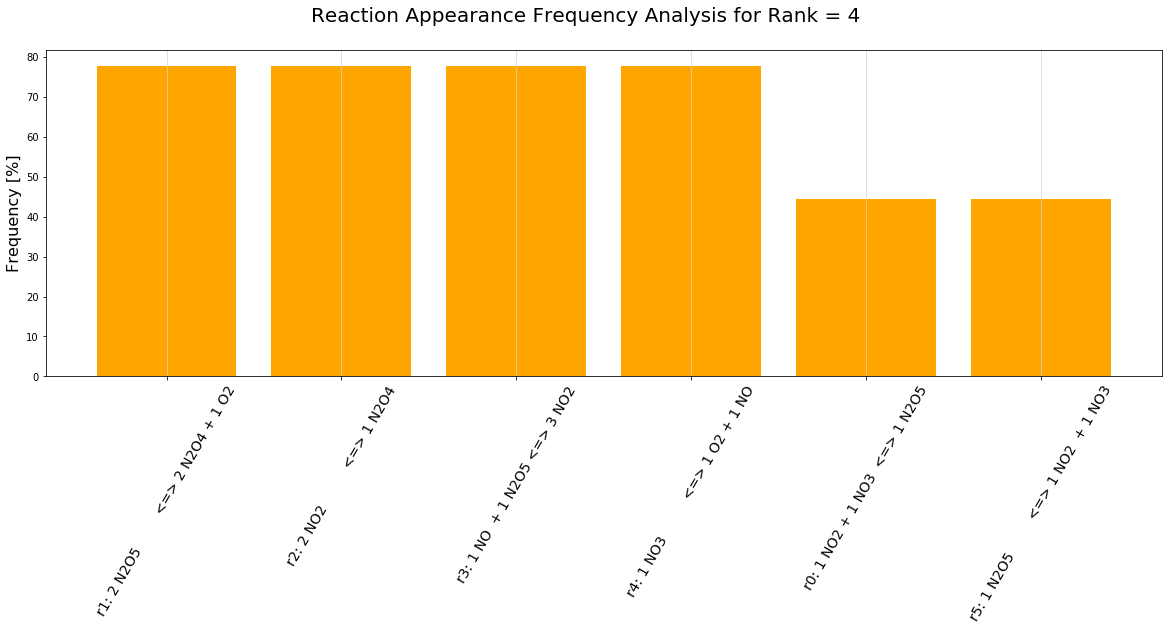

In [18]:
'''Plot the frequency of appearance of reactions in sub-mechanisms'''

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [25, 4]

fig, ax = plt.subplots(figsize=(20,6))

sort_results = sorted(
               zip( reactions, reactions_hits/len(sub_mech_reactions)*100 ), 
                   key = lambda entry: entry[1], reverse=True 
                     )

reactions_sorted = [a for (a,b) in sort_results]
hits_sorted = [b for (a,b) in sort_results]

ax.bar( reactions_sorted, hits_sorted, color='orange' )

for r in reactions_sorted:
    idx = reactions.index(r)
    i = reactions_sorted.index(r)
    reactions_sorted[i] = 'r'+str(idx)+': '+ r
    
plt.xticks( range(len(reactions)), reactions_sorted, rotation=60, fontsize=14 )

ax.set_ylabel('Frequency [%]',fontsize=16)
ax.xaxis.grid( True, linestyle='-', which='major', color='lightgrey',alpha=0.9)
fig.suptitle('Reaction Appearance Frequency Analysis for Rank = '+str(s_rank), fontsize=20)
plt.show()

In [15]:
'''Sorting reaction sub-mechanisms based on frequency'''

sub_mech_reactions_score = list()

for s in sub_mech_reactions:
    score = 0
    for i in s[0]:
        score += reactions_hits[i]
    sub_mech_reactions_score.append( score )

sub_mech_reactions_score = np.array( sub_mech_reactions_score ) 
sub_mech_reactions_score /= sub_mech_reactions_score.max()
sub_mech_reactions_score *= 10.0


results = sorted( zip( sub_mech_reactions, sub_mech_reactions_score ), 
                  key=lambda entry: entry[1], reverse=True )

sub_mech_reactions       = [a for (a,b) in results]
sub_mech_reactions_score = [b for (a,b) in results]

# encode score in to sub_mech_reactions mech. data structure
for (smr, score) in zip( sub_mech_reactions, sub_mech_reactions_score):
    smr += [score] # concatenation of lists

## Principal reaction sub-mechanisms<a id="principal"></a>


In [16]:
'''Principal reaction sub-mechanisms'''

max_score = max( [sr[2] for sr in sub_mech_reactions] )

for smr  in sub_mech_reactions:
    if smr[2] < max_score: continue # skip all but maximum
    print('Linearly Independent Reaction Set %s score %s'%\
          ( sub_mech_reactions.index(smr), smr[2]) )
    for (i,r) in zip(smr[0],smr[1]):
        print('r%s'%i,r)

Linearly Independent Reaction Set 0 score 10.0
r1 2 N2O5         <=> 2 N2O4 + 1 O2
r2 2 NO2          <=> 1 N2O4
r3 1 NO  + 1 N2O5 <=> 3 NO2
r4 1 NO3          <=> 1 O2 + 1 NO


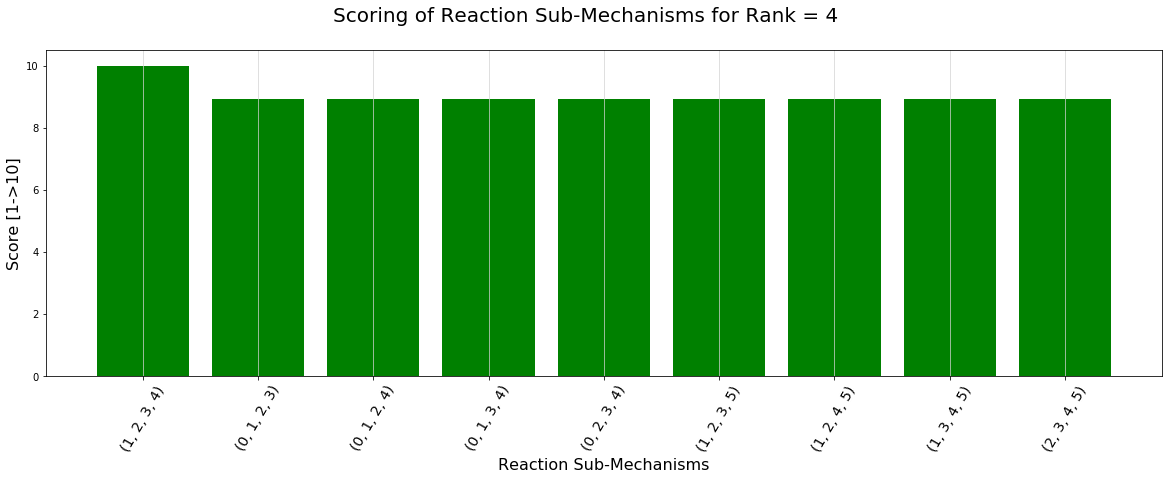

In [17]:
'''Principal reaction sub-mechanisms plot'''

fig, ax = plt.subplots(figsize=(20,6))

ax.bar(range(len(sub_mech_reactions)), [smr[2] for smr in sub_mech_reactions],color='green')

plt.xticks( range(len(sub_mech_reactions)), [smr[0] for smr in sub_mech_reactions], rotation=60,fontsize=14)

ax.set_ylabel('Score [1->10]',fontsize=16)
ax.set_xlabel('Reaction Sub-Mechanisms',fontsize=16)
ax.xaxis.grid(True,linestyle='-',which='major',color='lightgrey',alpha=0.9)
fig.suptitle('Scoring of Reaction Sub-Mechanisms for Rank = '+str(s_rank),fontsize=20)
plt.show()